In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.linear_model

from scipy.stats import spearmanr as cor

# Visualizing data

In this project, we worked on the daily yield curve data for the US bond. Each data point represents a "spot rate" at a particular maturity level for a paticular day ranging from 1990/1/02 to 2017/6 (current). On the plot below. you can observe a peridic trand as well as general decreasing nature of the interest rates. 

The data is obtained from https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll, and the csv version can be downloaded from https://docs.google.com/spreadsheets/d/1CHTTtS5NBdsScRbYm1YUtP4toFnI2q8OlB1EvixK7pY/edit#gid=0.

In [2]:
def convertentry(e):
    if e == "N/A": return -1
    elif "/" in e: return e
    else: return float(e)

In [4]:
raw = [i.rstrip().split(",") for i in open("../../data/forex_crosses/treasure.csv", "r").readlines()]
header = np.array(raw[0])
data = np.array([[convertentry(j) for j in i[1:]] for i in raw[1:]])
dates = [i[0] for i in raw[1:]]

In [6]:
data.shape

(6873, 11)

1 Mo data is missing: 2990 out of 6873
3 Mo data is missing: 20 out of 6873
6 Mo data is missing: 1 out of 6873
1 Yr data is missing: 1 out of 6873
2 Yr data is missing: 1 out of 6873
3 Yr data is missing: 1 out of 6873
5 Yr data is missing: 1 out of 6873
7 Yr data is missing: 1 out of 6873
10 Yr data is missing: 1 out of 6873
20 Yr data is missing: 940 out of 6873
30 Yr data is missing: 995 out of 6873


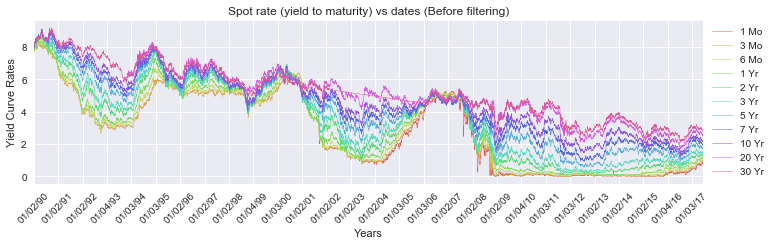

In [5]:
plt.figure(figsize=(12,3))
colors = sns.color_palette("hls", data.shape[1])
for i in range(data.shape[1]):
    temp = [(j,data[:, i][j]) for j in range(len(data[:, i])) if data[:, i][j] > 0]
    print header[i+1], "data is missing:", data.shape[0]-len(temp), "out of", data.shape[0]
    
    plt.plot([j[0] for j in temp], [j[1] for j in temp], label=header[i+1], linewidth=0.5, color=colors[i])
plt.ylabel("Yield Curve Rates")
plt.xlabel("Years")
plt.title("Spot rate (yield to maturity) vs dates (Before filtering)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, data.shape[0])

count = 0
mem = ""
locations = []
ticks = []
for i in dates:
    if i[-2:] != mem:
        mem = i[-2:]
        locations.append(count)
        ticks.append(i)
    count += 1
plt.xticks(locations, ticks, rotation=45)
plt.show()

In [193]:
# Removing 1Mo, 20Yr, 30 Yr columns are removed. 
temp = data[:, [1,2,3,4,5,6,7,8]]
#data2 = np.sqrt(data2)
print "Using", header[1:][[1,2,3,4,5,6,7,8]]
header2 = header[1:][[1,2,3,4,5,6,7,8]]

Using ['3 Mo' '6 Mo' '1 Yr' '2 Yr' '3 Yr' '5 Yr' '7 Yr' '10 Yr']


In [194]:
# Removes rows that have 0s in it.
def remove0rows(X):
    mask = (X>0).astype(np.bool_)
    temp = np.sum(mask, axis=1)
    index = [i for i in range(mask.shape[0]) if temp[i] == X.shape[1]]
    print "Removed", len([i for i in temp if i != X.shape[1]])
    return X[index, :]

In [195]:
data2 = remove0rows(temp)

Removed 20


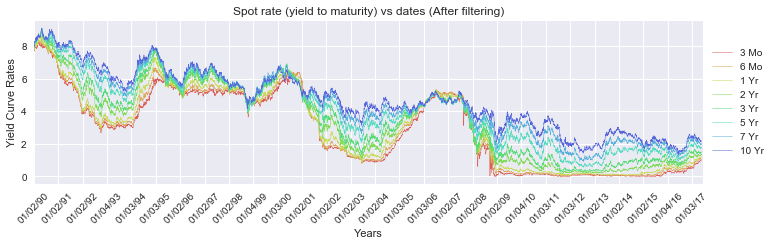

In [196]:
plt.figure(figsize=(12,3))
colors = sns.color_palette("hls", data.shape[1])
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], label=header2[i], linewidth=0.5, color=colors[i])
plt.ylabel("Yield Curve Rates")
plt.xlabel("Years")
plt.title("Spot rate (yield to maturity) vs dates (After filtering)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, data.shape[0])
plt.xticks(locations, ticks, rotation=45)
plt.show()

In [197]:
# Differencing at order of x:
# Throws away the first x observation for taking differences.
def differ(data, x=1):
    for j in range(x):
        ret = np.zeros((data.shape[0]-1, data.shape[1]))
        for i in range(data.shape[0]-1):
            ret[i] = data[i+1]-data[i]
        data = ret
    return data

In [198]:
data_stationary = differ(np.sqrt(data2), 1)

The first order difference figure below indicates that the US bond price behave differently between pre and post subprime mortgage crisis (2007-2010). The data is more stationary with the transformation (square root and 1st order difference), so the forcasting might perform better. 

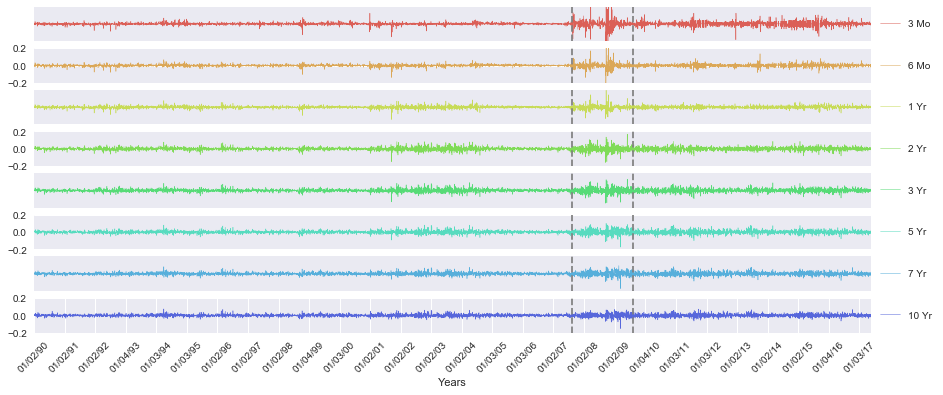

In [199]:
plt.figure(figsize=(15,6))
colors = sns.color_palette("hls", data.shape[1])
for i in range(data_stationary.shape[1]):
    plt.subplot(8,1,i+1)
    plt.plot(data_stationary[:, i], label=header2[i], linewidth=0.5, color=colors[i])
    plt.xlim(0, data_stationary.shape[0])
    plt.ylim(-0.2, 0.2)
    if i%2 == 0: 
        plt.yticks([],[])
    plt.xticks([], [])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axvline(4400, color="gray", ls="--")
    plt.axvline(4900, color="gray", ls="--")
plt.xlabel("Years")
plt.xticks(locations, ticks, rotation=45)
plt.show()

In [200]:
scaler = MinMaxScaler(feature_range=(0, 1))
data2 = scaler.fit_transform(data2)

# PCA and replicating the result of Francis et al.

It has been shown that the yield curves can be decomposed into 3 main features; level, slope, and curveture (Francis et al). This section replicates the claim by conducting PCA analysis on the data and fitting the first three principal componets to level (10Y yield), slope (10Y-3M), and curvature (10Y+6M-2\*5Y). One can clearly observe high correlation between the PCs and suggested features. In fact, the three PCs together capture 97% of the variance in data.

In [14]:
pca = PCA(3)
pcaed_data = pca.fit_transform(data2)

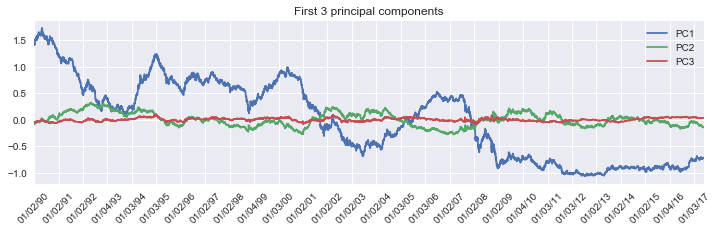

In [15]:
plt.figure(figsize=(12,3))
for i in range(pcaed_data.shape[1]):
    plt.plot(pcaed_data[:, i], label="PC"+str(i+1))
plt.title("First 3 principal components")
plt.xlim(0,pcaed_data.shape[0])
plt.legend()
plt.xticks(locations, ticks, rotation=45)
plt.show()

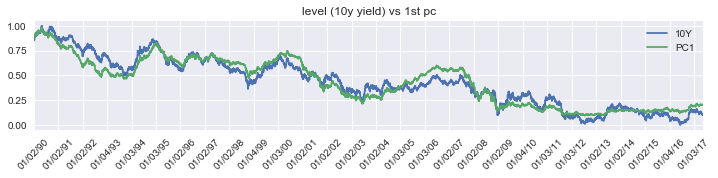

Spearman: 0.95850558868


In [16]:
m = sklearn.linear_model.LinearRegression()
m.fit(pcaed_data[:, 0:1], data2[:,-1])
fit_data = m.predict(pcaed_data[:, 0:1])

plt.figure(figsize=(12,2))
plt.plot(data2[:, -1], label="10Y")
plt.plot(fit_data, label="PC1")
plt.xlim(0, pcaed_data.shape[0])
plt.title("level (10y yield) vs 1st pc")
plt.xticks(locations, ticks, rotation=45)
plt.legend()
plt.show()

print "Spearman:", cor(data2[:,-1], fit_data)[0]

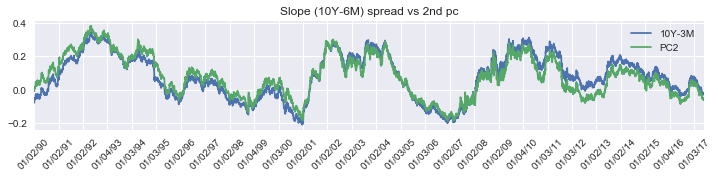

Spearman: 0.935662529481


In [17]:
m = sklearn.linear_model.LinearRegression()
m.fit(pcaed_data[:, 1:2], data2[:,-1]-data2[:,1])
fit_data = m.predict(pcaed_data[:, 1:2])

plt.figure(figsize=(12,2))
plt.plot(data2[:,-1]-data2[:,1], label="10Y-3M")
plt.plot(fit_data, label="PC2")
plt.xlim(0, pcaed_data.shape[0])
plt.title("Slope (10Y-6M) spread vs 2nd pc")
plt.xticks(locations, ticks, rotation=45)
plt.legend()
plt.show()

print "Spearman:", cor(data2[:,-1]-data2[:,1], fit_data)[0]

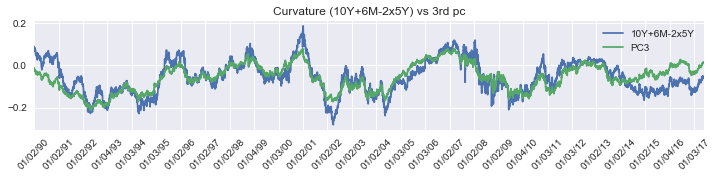

Spearman: 0.790782275084


In [18]:
m = sklearn.linear_model.LinearRegression()
m.fit(pcaed_data[:, 1:2], data2[:, 0]+data2[:,-1]-2*data2[:, -3])
fit_data = m.predict(pcaed_data[:, 1:2])

plt.figure(figsize=(12,2))
plt.plot(data2[:, 0]+data2[:,-1]-2*data2[:,-3], label="10Y+6M-2x5Y")
plt.plot(fit_data, label="PC3")
plt.xlim(0, pcaed_data.shape[0])
plt.title("Curvature (10Y+6M-2x5Y) vs 3rd pc")
plt.xticks(locations, ticks, rotation=45)
plt.legend()
plt.show()

print "Spearman:", cor(data2[:, 0]+data2[:,-1]-2*data2[:,-3], fit_data)[0]

# Preparing data

We are using 8 by 1 vectors from past 30 days (240 features) to predict a vector at t+h, where $h\in\{1,7,30,180,364\}$.  
We also  use 3 (PCs) by 1 vectors from past 30 days (90 features) to predict a 3 by 1 vector at t+h.

Notes about the details of sample preparation:
    - removed data from 1 Mo, 20 Yr, and 30 Yr maturity, because the sigificant amount of data points are missing.
    - removed remaining data that is missing at least one record.
    - Training and validationg sets: 1990-2008  (~70%)  
    - Testing: 2009-current (~30%)

In [201]:
futures = [1, 7, 30, 180]

In [202]:
def generate_data(source, testsplit=5000, trainsplit=3000, shuffle=False, verbose=False):
    
    # preparind data split.
    index = range(testsplit)
    if shuffle: np.random.shuffle(index)
    trainindex = index[:trainsplit]
    validindex = index[trainsplit:]
    
    # definining horizons
    futures = [1, 7, 30, 180, 360]
    
    # deciding how many past days to use for making predictions
    date_window = 180
    span = 30
    
    data = {}
    
    # applying PCA transformation
    pca = PCA(3)
    pcaed_source = pca.fit_transform(source)
    
    # generating data
    for future in futures:
        X = []
        Y = []
        pcaed_X = []
    
        for i in range(source.shape[0]-(date_window+future-1)):
            x = source[i:i+date_window, :][range(span-1,date_window,span),:].reshape((8*date_window/span,))
            x_pca = pcaed_source[i:i+date_window, :][range(span-1,date_window,span),:].reshape((3*date_window/span,))

            y = source[i+date_window+future-1, :].reshape((8,))

            X.append(x)
            Y.append(y)
            pcaed_X.append(x_pca)
            
        if verbose: print "Using past", date_window, "days to predict", future, "days ahead."
        if verbose: print missing, "samples contained missing values."
        X = np.array(X)
        pcaed_X = np.array(pcaed_X)
        Y = np.array(Y)
        if verbose: print "Data shapes:", X.shape, Y.shape

        x_train = X[trainindex, :]
        x_train_pca = pcaed_X[trainindex, :]
        y_train = Y[trainindex, :]
        if verbose: print "Train:", x_train.shape, y_train.shape

        x_valid = X[validindex, :]
        x_valid_pca = pcaed_X[validindex, :]
        y_valid = Y[validindex, :]
        if verbose: print "Valid:", x_valid.shape, y_valid.shape

        x_test = X[testsplit:, :]
        x_test_pca = pcaed_X[testsplit:, :]
        y_test = Y[testsplit:, :]
        if verbose: print "Test:", x_test.shape, y_test.shape
        if verbose: print

        temp = {}
        temp["train"] = (y_train, x_train, x_train_pca)
        temp["valid"] = (y_valid, x_valid, x_valid_pca)
        temp["test"] = (y_test, x_test,  x_test_pca)

        data[future] = temp
        
    return data, pca

In [203]:
raw_data, raw_pca = generate_data(data2)

In [120]:
#raw_data, raw_pca = generate_data(data_stationary)

In [121]:
def MSE(y,y_hat):
    return np.mean((y-y_hat)**2)

# Benchmarking with "Random walk".

For the benchmarking purpose, we formulate our prediction problem as follows.

$ X_{i,t+h} = X_{i,t} $

where $X$ is our data matrix, $i$ is maturity level, and $h$ is the number of steps we are predicting ahead.

We cound also predict only based on the first 3 principal components as they capture 97% of variance toghether.  
The prediction then can be reconstucted from the PCs after making prdictions.

Specifically we use last row of $X$ as a prediction for $X_{t+h}$

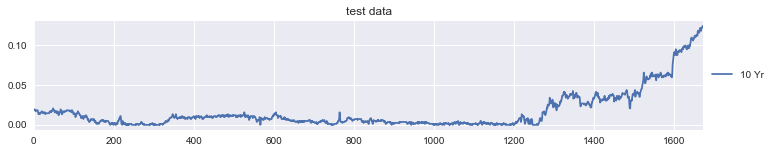

In [205]:
plt.figure(figsize=(12,2))
plt.plot(raw_data[1]["test"][0][:, 0], label=header2[i])

plt.legend()
plt.xlim(0,raw_data[1]["test"][0].shape[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("test data")
plt.show()

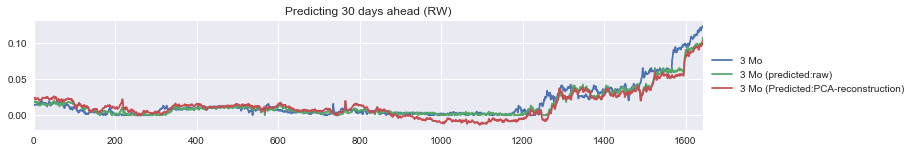

In [206]:
future = 30
target = 0

plt.figure(figsize=(12,2))
prediction = raw_data[future]["test"][1][:,-8:]
plt.plot(raw_data[future]["test"][0][:, target], label=header2[target])
plt.plot(prediction[:, target], label=header2[target]+" (predicted:raw)")
plt.plot(raw_pca.inverse_transform(raw_pca.transform(prediction))[:, target], label=header2[target]+" (Predicted:PCA-reconstruction)")

plt.legend()
plt.xlim(0,len(prediction))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (RW)")
plt.show()

In [124]:
for i in futures:
    print "Horizon:", i, "days"
    prediction = raw_data[i]["test"][1][:,-8:]
    print "Raw random walk", MSE(raw_data[i]["test"][0], prediction)
    print "PCA random walk", MSE(raw_data[i]["test"][0], raw_pca.inverse_transform(raw_pca.transform(prediction)))
    print

Horizon: 1 days
Raw random walk 1.85172199256e-05
PCA random walk 5.3466663233e-05

Horizon: 7 days
Raw random walk 0.000121415891502
PCA random walk 0.000153678268156

Horizon: 30 days
Raw random walk 0.000478097819157
PCA random walk 0.000504016768444

Horizon: 180 days
Raw random walk 0.00258220262749
PCA random walk 0.00258796407939

Horizon: 360 days
Raw random walk 0.00402676851804
PCA random walk 0.00399719624461



# Buidling AR(18) model (Francis et al)

We are using AR(18) model as a baseline. Basically we are using each PCA component as an independent factor and trying to predict the value of that factor at $t+h$ as a linear combination of past $k$ observations of that factor. Finally, the factors are PCA reconstructed to get the orignal value. The model is **NOT** regularized as it is shown in the paper. As we do not need to select regularization parameters, the model is trained on "train+valid" set.

AR model does not generalized well. Fits the training data better but do poorly even worse than RW on the test set. This is clearly the issue of AR model proposed by Francis et al. The model needs to be fucking generalized. The fact that it works very mergnally better at predictiing 3-month spotrate 1 month ahead agrees with francis et al.

In [209]:
future = 30
y_train = raw_pca.transform(raw_data[future]["train"][0])
x_train = raw_data[future]["train"][2]
y_test = raw_pca.transform(raw_data[future]["test"][0])
x_test = raw_data[future]["test"][2]

In [210]:
prediction = []
prediction2 = []
for i in range(3):
    lr = sklearn.linear_model.LinearRegression()
    lr.fit(x_train[:, range(i,x_train.shape[1],3)], y_train[:, i])
    prediction.append(lr.predict(x_train[:, range(i,x_train.shape[1],3)]))
    prediction2.append(lr.predict(x_test[:, range(i,x_train.shape[1],3)]))
prediction = np.transpose(np.array(prediction))
prediction2 = np.transpose(np.array(prediction2))

In [211]:
target = -1
print "Training MSE (AR)", MSE(raw_data[future]["train"][0][:,target], raw_pca.inverse_transform(prediction)[:,target])
print "Training MSE (RW)", MSE(raw_data[future]["train"][0][:,target], raw_pca.inverse_transform(x_train[:,-3:])[:,target])

Training MSE (AR) 0.00182476198665
Training MSE (RW) 0.00192352238242


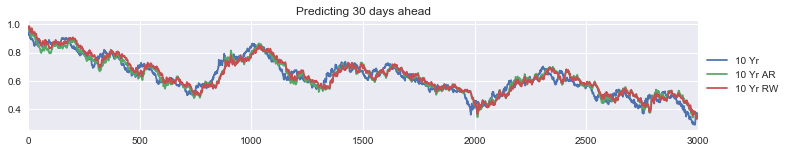

In [212]:
plt.figure(figsize=(12,2))
plt.plot(raw_data[future]["train"][0][:,target], label=header2[target])
plt.plot(raw_pca.inverse_transform(prediction)[:,target], label=header2[target]+" AR")
plt.plot(raw_pca.inverse_transform(x_train[:,-3:])[:,target], label=header2[target]+" RW")

plt.legend()
plt.xlim(0,len(prediction))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead")
plt.show()

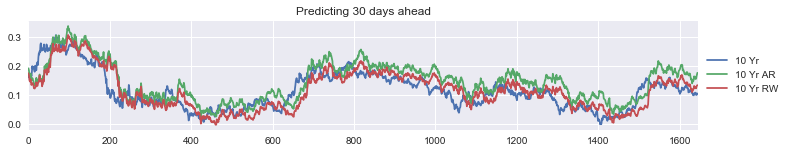

In [213]:
plt.figure(figsize=(12,2))
plt.plot(raw_data[future]["test"][0][:,target], label=header2[target])
plt.plot(raw_pca.inverse_transform(prediction2)[:,target], label=header2[target]+" AR")
plt.plot(raw_pca.inverse_transform(x_test[:,-3:])[:,target], label=header2[target]+" RW")

plt.legend()
plt.xlim(0,len(prediction2))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead")
plt.show()

In [214]:
for future in futures:
    y_train = raw_pca.transform(raw_data[future]["train"][0])
    x_train = raw_data[future]["train"][2]
    y_test = raw_pca.transform(raw_data[future]["test"][0])
    x_test = raw_data[future]["test"][2]
    
    prediction = []
    for i in range(3):
        lr = sklearn.linear_model.LinearRegression()
        lr.fit(x_train[:, range(i,x_train.shape[1],3)], y_train[:, i])
        prediction.append(lr.predict(x_test[:, range(i,x_train.shape[1],3)]))
    prediction = pca.inverse_transform(np.transpose(np.array(prediction)))
    
    assert raw_data[future]["test"][0].shape == prediction.shape
    target = 0
    
    print future, "days ahead. ("+ header2[target]+" maturity)"
    print "MSE (AR):", MSE(raw_data[future]["test"][0][:,target], prediction[:,target])
    print "MSE (RW):", MSE(raw_data[future]["test"][0][:,target], raw_pca.inverse_transform(x_test[:,-3:])[:,target])
    print "MSE (baseline):", MSE(raw_data[future]["test"][0][:,target], np.mean(raw_data[future]["test"][0][:,target]))
    print 

1 days ahead. (3 Mo maturity)
MSE (AR): 3.09235981978e-05
MSE (RW): 3.29019729256e-05
MSE (baseline): 0.000576879972869

7 days ahead. (3 Mo maturity)
MSE (AR): 7.21071658026e-05
MSE (RW): 4.78733671248e-05
MSE (baseline): 0.000578943043988

30 days ahead. (3 Mo maturity)
MSE (AR): 0.000896314081974
MSE (RW): 0.00010477116882
MSE (baseline): 0.000586996918795

180 days ahead. (3 Mo maturity)
MSE (AR): 0.0294092353686
MSE (RW): 0.000546777046474
MSE (baseline): 0.00064052760546

360 days ahead. (3 Mo maturity)
MSE (AR): 0.0888860417067
MSE (RW): 0.00106531470995
MSE (baseline): 0.000694060145342



# Regularized VAR(p) model. 

VAR(p) models a vector at t+h as a linear combination of p vectors from t-p to t.  

This is obviously not a good strategy as we do not expect the components of the vectors to move with perfect
correlation.

In [131]:
future = 30

y_train = raw_data[future]["train"][0]
x_train = raw_data[future]["train"][2]
y_valid = raw_data[future]["valid"][0]
x_valid = raw_data[future]["valid"][2]
y_test = raw_data[future]["test"][0]
x_test = raw_data[future]["test"][2]

In [132]:
reg = [10**(-1*(i)) for i in range(1, 8)]

In [133]:
target = 0

# Selecting best regularization term
MSEs = []
models = []

for a in reg:
    en = sklearn.linear_model.ElasticNet(alpha = a, max_iter=2000)
    en.fit(x_train, [i[target] for i in y_train])
    
    prediction = en.predict(x_valid)
    truth = np.array([i[target] for i in y_valid])
    MSEs.append(MSE(prediction, truth))
    models.append(en)

3 Mo


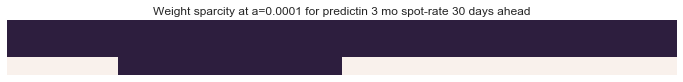

In [134]:
print header2[target]
index = -4

plt.figure(figsize=(12,1))
sns.heatmap(np.transpose((models[index].coef_.reshape((x_test.shape[1]/3,3))!=0).astype(np.int_)), cbar=False)
plt.xticks([],[])
plt.yticks([],[])

plt.title("Weight sparcity at a="+str(reg[index])+" for predictin 3 mo spot-rate 30 days ahead")
plt.show()

In [135]:
mask = (models[index].coef_!=0).astype(np.bool_)
sum(mask)

14

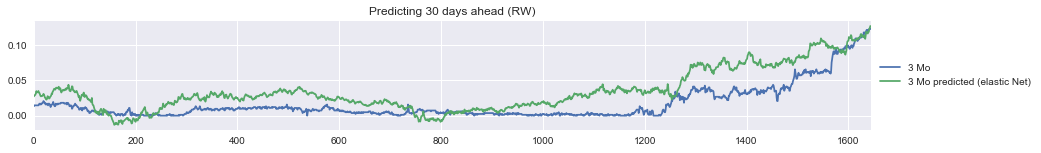

0
0.000525628744495


In [136]:
prediction = models[index].predict(x_test)

plt.figure(figsize=(15,2))
plt.plot(y_test[:,target], label=header2[target])
plt.plot(prediction, label=header2[target]+" predicted (elastic Net)")

plt.legend()
plt.xlim(0,len(prediction))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (RW)")
plt.show()

print target
print MSE(prediction, y_test[:,target])

# Deep Neural Nets (4 layer MLP)

In [137]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Merge
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
from keras.models import load_model

In [138]:
future = 30

y_train = raw_data[future]["train"][0]
x_train = raw_data[future]["train"][2]#[:, mask]
y_valid = raw_data[future]["valid"][0]
x_valid = raw_data[future]["valid"][2]#[:, mask]
y_test = raw_data[future]["test"][0]
x_test = raw_data[future]["test"][2]#[:, mask]

In [162]:
model = Sequential()
#model.add(Dense(20, input_shape=(sum(mask),)))
model.add(Dense(20, input_shape=(x_test.shape[1],)))
model.add(Activation("tanh")) #tried relu
model.add(Dense(10)) 
model.add(Activation("tanh")) #tried relu
model.add(Dense(8))
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam', loss='poisson', metrics=['accuracy'])

In [163]:
filepath="bestmodel.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [169]:
result = model.fit(x_train, y_train,
          epochs=50, 
          batch_size=256,
          callbacks=callbacks_list,
          validation_data=(x_valid, y_valid),
          verbose=0
          )

Epoch 00000: val_loss did not improve
Epoch 00001: val_loss improved from 0.00391 to 0.00389, saving model to bestmodel.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 0.00389 to 0.00380, saving model to bestmodel.hdf5
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did not improve
Epoch 00020: val_loss did not improve
Epoch 00021: val_loss did not improve
Epoch 00022: val_loss did not improve
Epoch 00023: val_loss did no

In [170]:
model = load_model("./bestmodel.hdf5")

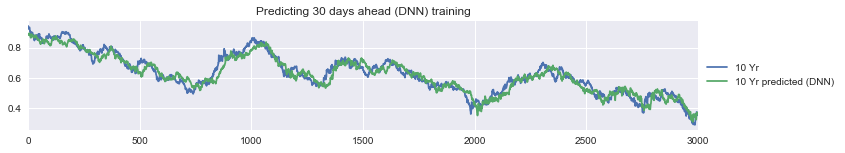

0.00147610035944


In [171]:
target = 7
prediction = model.predict(x_train)
plt.figure(figsize=(12,2))
plt.plot(y_train[:,target], label=header2[target])
plt.plot(prediction[:, target], label=header2[target]+" predicted (DNN)")

plt.legend()
plt.xlim(0,len(prediction[:, target]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (DNN) training")
plt.show()

print MSE(prediction[:,target], y_train[:,target])

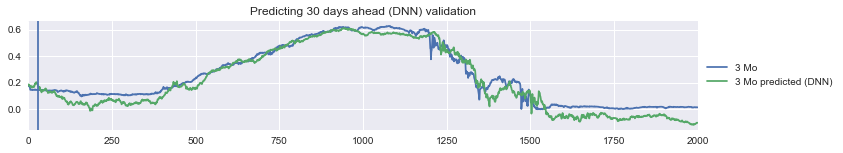

0.00353844515654


In [172]:
target = 0
prediction = model.predict(x_valid)
plt.figure(figsize=(12,2))
plt.plot(y_valid[:,target], label=header2[target])
plt.plot(prediction[:, target], label=header2[target]+" predicted (DNN)")

plt.legend()
plt.xlim(0,len(prediction[:, target]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (DNN) validation")
plt.axvline(30)
plt.show()

print MSE(prediction[:,target], y_valid[:,target])

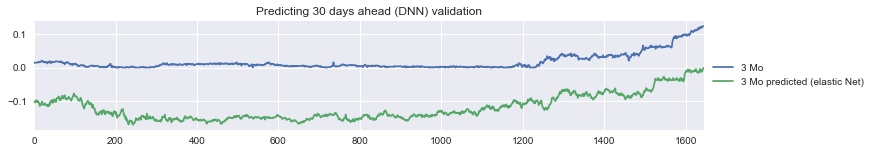

0.0191572127908


In [173]:
target = 0
prediction = model.predict(x_test)
plt.figure(figsize=(12,2))
plt.plot(y_test[:,target], label=header2[target])
plt.plot(prediction[:, target], label=header2[target]+" predicted (elastic Net)")

plt.legend()
plt.xlim(0,len(prediction[:, target]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (DNN) validation")
plt.show()

print MSE(prediction[:,target], y_test[:,target])

# LSTM (2 layer) 

In [174]:
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [90]:
print x_test.shape[1]/3

60


In [175]:
future = 30

y_train = raw_data[future]["train"][0]
x_train = raw_data[future]["train"][2]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]/3, 3))
y_valid = raw_data[future]["valid"][0]
x_valid = raw_data[future]["valid"][2]
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1]/3, 3))
y_test = raw_data[future]["test"][0]
x_test = raw_data[future]["test"][2]
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]/3, 3))

In [176]:
model = Sequential()
#model.add(LSTM(20, input_shape=(18, 3), return_sequences=True))
model.add(LSTM(20, input_shape=(x_test.shape[1], 3)))
model.add(Dense(8))
model.compile(loss='mean_squared_error', optimizer="adam")

In [177]:
filepath="bestmodel2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [184]:
result = model.fit(np.transpose(x_train, [0,1,2]), y_train,
          epochs=50, 
          batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=0, 
          validation_data=(x_valid, y_valid),
          verbose=0
          )

Epoch 00000: val_loss improved from 0.00667 to 0.00667, saving model to bestmodel2.hdf5
Epoch 00001: val_loss improved from 0.00667 to 0.00666, saving model to bestmodel2.hdf5
Epoch 00002: val_loss improved from 0.00666 to 0.00661, saving model to bestmodel2.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.00661 to 0.00658, saving model to bestmodel2.hdf5
Epoch 00005: val_loss improved from 0.00658 to 0.00658, saving model to bestmodel2.hdf5
Epoch 00006: val_loss improved from 0.00658 to 0.00654, saving model to bestmodel2.hdf5
Epoch 00007: val_loss improved from 0.00654 to 0.00652, saving model to bestmodel2.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.00652 to 0.00646, saving model to bestmodel2.hdf5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not 

In [185]:
model = load_model("./bestmodel2.hdf5")

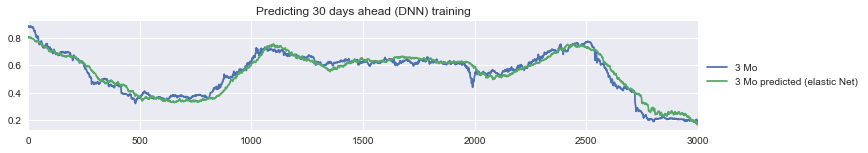

0.00143942866433


In [186]:
target = 0
prediction = model.predict(x_train)
plt.figure(figsize=(12,2))
plt.plot(y_train[:,target], label=header2[target])
plt.plot(prediction[:, target], label=header2[target]+" predicted (elastic Net)")

plt.legend()
plt.xlim(0,len(prediction[:, target]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (DNN) training")
plt.show()

print MSE(prediction[:,target], y_train[:,target])

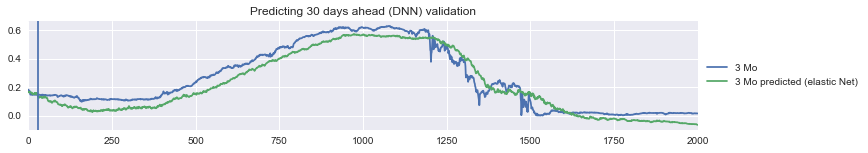

0.004255935899


In [187]:
target = 0
prediction = model.predict(x_valid)
plt.figure(figsize=(12,2))
plt.plot(y_valid[:,target], label=header2[target])
plt.plot(prediction[:, target], label=header2[target]+" predicted (elastic Net)")

plt.legend()
plt.xlim(0,len(prediction[:, target]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (DNN) validation")
plt.axvline(30)
plt.show()

print MSE(prediction[:,target], y_valid[:,target])

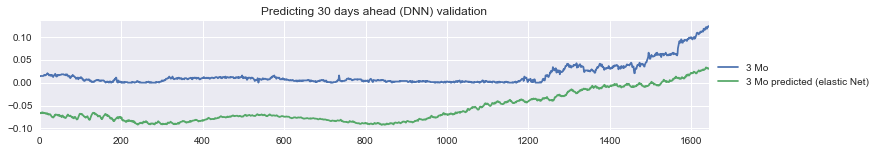

0.00575606810893


In [188]:
target = 0
prediction = model.predict(x_test)
plt.figure(figsize=(12,2))
plt.plot(y_test[:,target], label=header2[target])
plt.plot(prediction[:, target], label=header2[target]+" predicted (elastic Net)")

plt.legend()
plt.xlim(0,len(prediction[:, target]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Predicting "+str(future)+" days ahead (DNN) validation")
plt.show()

print MSE(prediction[:,target], y_test[:,target])